# Pre-Processing

In [75]:
# Let us start by importing the library from the package directory
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# Read the data
# df = pd.read_csv("./train.csv")
df_train = pd.read_csv("drive/MyDrive/MLProject/train.csv")
df_test = pd.read_csv("drive/MyDrive/MLProject/test.csv")

# Cosmetics for matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

rcParams['figure.figsize'] = 18, 9
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 'smaller'
rcParams['ytick.labelsize'] = 'smaller'
rcParams['axes.labelpad'] = 15

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
df = pd.concat([df_train, df_test])

In [78]:
df_test.head()

,id,text
0,e0ae9d9474a5689a5791,in an interview before his execution
1,b64a191301cad4f11287,He knew what he was doing. The below posts are...
2,5e1953d9ae04bdc66408,Zzzzzzz... youre a real bore. Now go bore some...
3,23128f98196c8e8f7b90,"""\n\nYet, it remains confusion because the 910..."
4,2d3f1254f71472bf2b78,I was referring to them losing interest in van...


In [79]:
# Check the first five rows of our dataset
df.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0.0,0.0,0.0,0.0,0.0,0.0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0.0,0.0,0.0,0.0,0.0,0.0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1.0,0.0,0.0,0.0,0.0,0.0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1.0,0.0,1.0,1.0,1.0,0.0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
df.describe()

,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
count,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000
mean,0.095782,0.010262,0.053067,0.002999,0.049150,0.008975
std,0.294294,0.100781,0.224168,0.054683,0.216182,0.094311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Remove urls

In [81]:
import re

def clean_url(review_text):
    return re.sub(r'http\S+', ' ', review_text)

df['text'] = df['text'].apply(clean_url)

### Remove html tags

In [82]:
def clean_html_tags(review_text):
    return re.sub('<[^<]+?>', '', review_text)

df['text'] = df['text'].apply(clean_url)

### Remove numbers and punctuation

In [83]:
def clean_non_alphanumeric(review_text):
    return re.sub('[^a-zA-Z]', ' ', review_text)

df['text'] = df['text'].apply(clean_non_alphanumeric)

In [84]:
df['text'].iloc[0]

'     December       UTC  I am interested  not in arguing  but in the policies which resolve our ongoing content dispute  Also  see Wikipedia  WikiProject United States presidential elections for what I ll be working on  Also  the moneybomb closer just self reverted on two different requests  which echoed what I would have requested   I will rephrase     which I didn t see an answer to  building on our agreement that   moneybomb   should not be a redlink  Given the deletion reversion  what should be the outline of the article called   moneybomb   or should it be submitted for AFD again in due time   If the latter  see the previous version of      However  this version will require a detailed answer because any ambiguity will only necessitate clarifying questions          '

Removing extra white-spaces

In [85]:
df['text'] = df['text'].apply(lambda x : " ".join(x.split()))

In [86]:
df['text'].iloc[0]

'December UTC I am interested not in arguing but in the policies which resolve our ongoing content dispute Also see Wikipedia WikiProject United States presidential elections for what I ll be working on Also the moneybomb closer just self reverted on two different requests which echoed what I would have requested I will rephrase which I didn t see an answer to building on our agreement that moneybomb should not be a redlink Given the deletion reversion what should be the outline of the article called moneybomb or should it be submitted for AFD again in due time If the latter see the previous version of However this version will require a detailed answer because any ambiguity will only necessitate clarifying questions'

### Spell Checker

In Natural Language Processing it’s important that spelling errors should be as less as possible so that whatever we are making should be highly accurate.

In [87]:
# from textblob import TextBlob

# df['text'] = df['text'].apply(lambda x : TextBlob(x).correct())

### Lemmatization

Comparing between Lemmatization and stemming

Stemming just removes or stems the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma. Sometimes, the same word can have multiple different Lemmas.

* If you lemmatize the word 'Caring', it would return 'Care'. If you stem, it would return 'Car' and this is erroneous.

* If you lemmatize the word 'Stripes' in verb context, it would return 'Strip'. If you lemmatize it in noun context, it would return 'Stripe'. If you just stem it, it would just return 'Strip'.
* You would get same results whether you lemmatize or stem words such as walking, running, swimming... to walk, run, swim etc.

![LVS](assets/LVS.png "Lemmatization vs Stemming")

In [88]:
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

df['text'] = df['text'].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='n') for w in x.split(" ")]))
df['text'] = df['text'].apply(lambda x : " ".join([lemma.lemmatize(word = w, pos='v') for w in x.split(" ")]))

In [89]:
df['text'].iloc[0]

'December UTC I be interest not in argue but in the policy which resolve our ongoing content dispute Also see Wikipedia WikiProject United States presidential election for what I ll be work on Also the moneybomb closer just self revert on two different request which echo what I would have request I will rephrase which I didn t see an answer to build on our agreement that moneybomb should not be a redlink Given the deletion reversion what should be the outline of the article call moneybomb or should it be submit for AFD again in due time If the latter see the previous version of However this version will require a detail answer because any ambiguity will only necessitate clarify question'

### Remove Stop Words

In [90]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

not_stop_words = {'no', 'not', 'nor'}
 
modified_stop = [ele for ele in stop if ele not in not_stop_words]

df['text'] = df['text'].apply(lambda x : ' '.join([word for word in x.split(' ') if word not in modified_stop]))



In [91]:
df.text

0        December UTC I interest not argue policy resol...
1        I add three miss parameter template infobox or...
2              SANDBOX I DID YOUR MADRE DID IN THE SANDBOX
3        good sir Why You sir obviously not comprehend ...
4        Source Incase I forget someone else want pick ...
                               ...                        
38292    Please refrain remove content Wikipedia Storm ...
38293                                          October UTC
38294    Listing Girls Alphabetical Order Who keep move...
38295    Dumb Fuck delete angry nintendo nerd page DUMB...
38296    Fine job I would never find log But look caref...
Name: text, Length: 127656, dtype: object

###Remove words of length <=2

In [92]:
def clean_small(review_text):
    return re.sub(r'\b\w{1,2}\b', '', review_text)

df['text'] = df['text'].apply(clean_small)

df['text'] = df['text'].apply(lambda x : " ".join(x.split()))

In [93]:
df['text'].iloc[0]

'December UTC interest not argue policy resolve ongoing content dispute Also see Wikipedia WikiProject United States presidential election work Also moneybomb closer self revert two different request echo would request rephrase see answer build agreement moneybomb not redlink Given deletion reversion outline article call moneybomb submit AFD due time latter see previous version However version require detail answer ambiguity necessitate clarify question'

# Todo
**Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon'.We will remove all such words which has three consecutive repeating characters.**

**stopwords without (no not aur nor)**

# EDA (Exploratory Data Analysis)

To get a better sense of our MultiLabel Classification we would start by plotting the number of texts in each category.

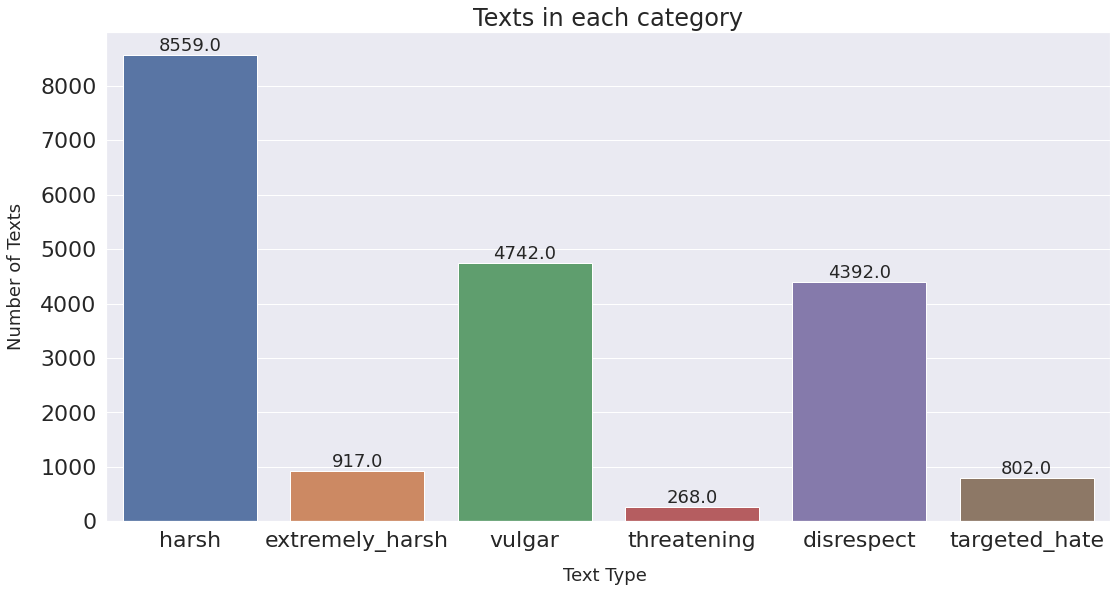

In [94]:
categories = list(df.columns.values)
categories.remove('id')
categories.remove('text')

sns.set(font_scale=2)

ax = sns.barplot(x=categories, y=df.iloc[:, 2:].sum().values)

plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=18)

rects = ax.patches
labels = df.iloc[:, 2:].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

**Observations**: Harsh is the most common type of text and is nearly equal to the sum of all other types of texts whereas threatening, extremely_harsh, targeted_hate are the rare ones among all of them. Some more interdependent labels will be discussed in later part of the module.

Now let us count the number of comments having multiple labels.

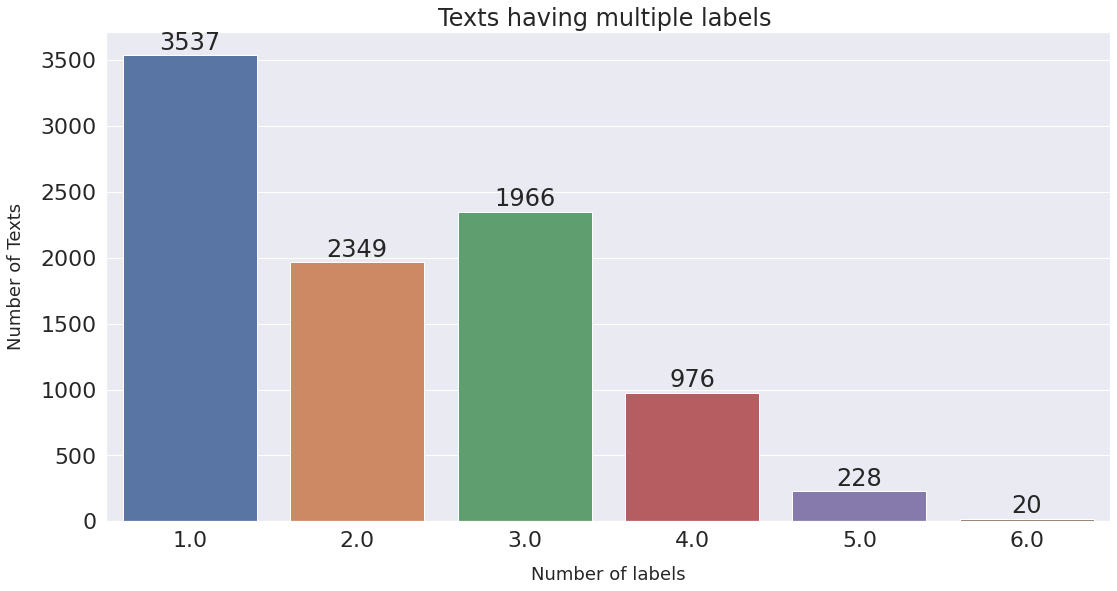

In [95]:
rowSums = df.iloc[:, 2:].sum(axis=1)

multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale=2)

ax = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values)

plt.title("Texts having multiple labels ")
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

# adding the text labels
rects = ax.patches
labels = multiLabel_counts.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
            
plt.show()

**Observations**: All 6 labels at the same time is extremely rare and only one label takes up the majority.

Now, let us find the top 20 words by frequency

In [96]:
corpus=[]
new = df['text'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

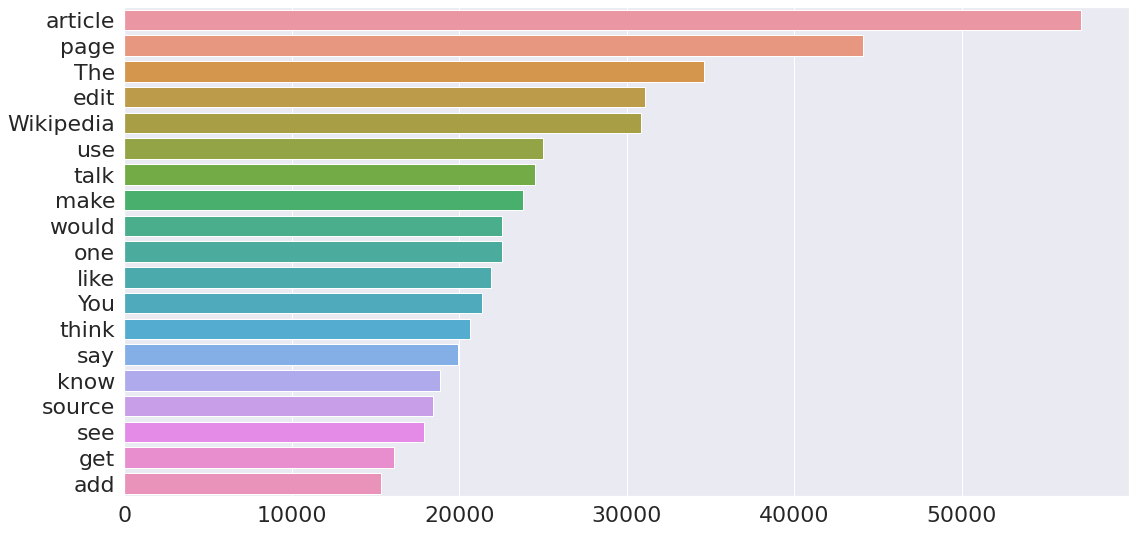

In [97]:
from collections import Counter

counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:20]:
    if (word not in stop):
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

Let us make a WordCloud to better understand the occurrences of the words which constitute in the majority.

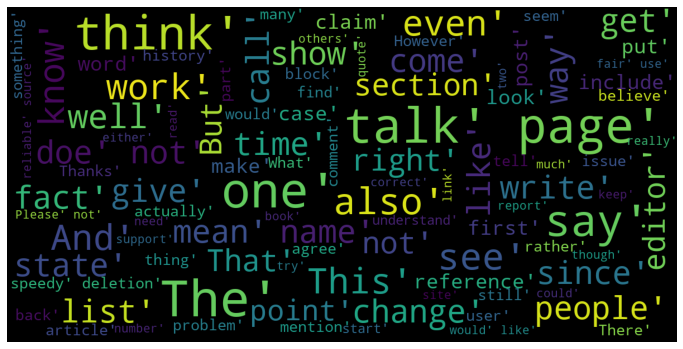

In [98]:
from wordcloud import WordCloud

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=modified_stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

**Observation**: We can see the top 20 words in the text and can say by intuition that the bad words that constitute to the target labels are not that common

Next, we will plot the length of comments. We can observe that most comments are less than 500 characters long.

Text(0, 0.5, 'Count of Comments')

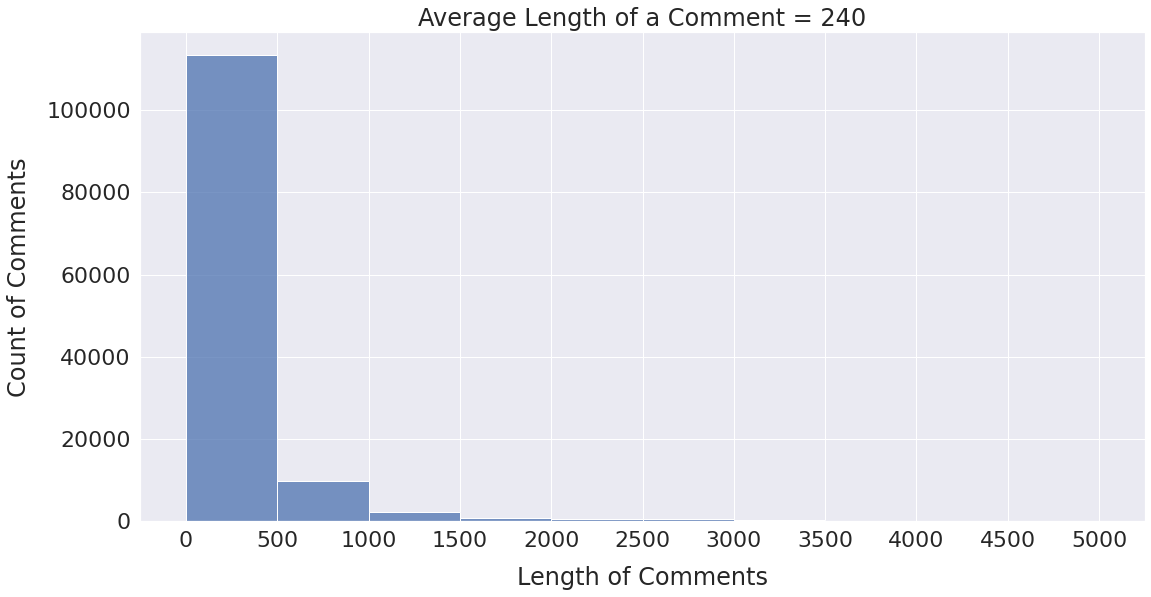

In [99]:
text_len = df.text.str.len()

plt.title("Average Length of a Comment = " + str(int(text_len.mean())))
plt.xticks(range(0, 5000+1, 500))

ax = sns.histplot(text_len, binwidth=500)
ax.set_xlabel('Length of Comments')
ax.set_ylabel('Count of Comments')

# Text -> Features

### BOW (Bag of Words)

Each text is represented as a vector consisting of the frequency / occurence(0,1) / weighted values of vocabulary (list of unique words).

![BOW](assets/BOW.png "Bag Of Words")

Disadvantages ->
1.	Vocabulary can become too large
2.	Each text vector will contain many 0's which will result in a sparse matrix (Why is that a problem?)
3.	Ordering of the words (grammar, meaning) is lost
4.	Words which occur frequently across all text vectors may introduce a bias.

### TF-IDF (Term Frequency and Inverse document Frequency)

TF-IDF kind of normalizes the text vectors. Frequent words in a text-vector are "rewarded", but they also get "punished" if they are frequent in other text-vectors too. Thus, higher weight is assigned to unique or rare terms considering all text-vectors.

TF(t,d) = (count of t in document d) / (Total words in document d)

IDF(t) = log(Total documents / Number of documents containing t)

![TF-IDF](assets/IDF.png "TF_IDF")

Disadvantages ->

1. TF-IDF is basically BOW with weights. It cannot capture the semantics / meaning of text.

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Explore other parameters of TfidVectorizer
vectorizer = TfidfVectorizer(binary=True, lowercase=True)

X = vectorizer.fit_transform(df['text'])

In [101]:
vectorizer.get_feature_names()

# Spell Check necessary?

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aaaa',
 'aaaaa',
 'aaaaaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany',
 'aaaaaaaaaah',
 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaahhhhhhhhhhhhhhhhhhhhhhhh',
 'aaaaaaw',
 'aaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreeee',
 'aaaawwww',
 'aaaboyz',
 'aaages',
 'aaaghh',
 'aaah',
 'aaahhh',
 'aaai',
 'aaajade',
 'aaand',
 'aaarrrgggh',
 'aaaww',
 'aab',
 'aaba',
 'aaberg',
 'aabove',
 'aac',
 'aachen',
 'aachi',
 'aacs',
 'aad',
 'aademia',
 'aadil',
 'aadmi',
 'aaffect',
 'aafia',
 'aaflight',
 'aafs',
 'aagadu',
 'aage',
 'aagin',
 'aah',
 'aahil',
 'aahoa',
 'aai',
 'aaiha',
 'aajacksoniv',
 'aajonus',
 'aakash',
 'aake',
 'aalborg',
 'aalertbot',
 'aalexa',
 'aaliya',
 'aaliyah',
 'aals',
 'aalst',
 'aam',
 'aamir',
 'aamirjamil',
 'aaml',
 'aamu',
 'aan',
 'aanas',
 'aand',
 'aang',
 'aao',
 'aaot',
 'aap',
 'aapl',
 'aapropriate',
 'aar',
 'aarabs',
 'aarau',
 'aardsma',
 'aardsman',
 'aardvark',
 'aare',
 'aarem',
 'aarionrhod',
 

In [102]:
vectorizer.vocabulary_

{'december': 28843,
 'utc': 124684,
 'interest': 57732,
 'not': 81631,
 'argue': 6857,
 'policy': 90467,
 'resolve': 98696,
 'ongoing': 83814,
 'content': 24615,
 'dispute': 32387,
 'also': 3883,
 'see': 104373,
 'wikipedia': 129770,
 'wikiproject': 129868,
 'united': 123313,
 'states': 111305,
 'presidential': 92025,
 'election': 36038,
 'work': 130982,
 'moneybomb': 76166,
 'closer': 22107,
 'self': 104574,
 'revert': 99162,
 'two': 121577,
 'different': 31333,
 'request': 98510,
 'echo': 35177,
 'would': 131143,
 'rephrase': 98276,
 'answer': 5402,
 'build': 16512,
 'agreement': 2443,
 'redlink': 96992,
 'given': 46814,
 'deletion': 29485,
 'reversion': 99159,
 'outline': 85141,
 'article': 7341,
 'call': 17538,
 'submit': 112753,
 'afd': 1976,
 'due': 34350,
 'time': 118483,
 'latter': 66140,
 'previous': 92171,
 'version': 125995,
 'however': 53666,
 'require': 98528,
 'detail': 30489,
 'ambiguity': 4175,
 'necessitate': 79364,
 'clarify': 21738,
 'question': 94718,
 'add': 1276,


# Train-Test Split

In [103]:
len(df_train)

89359

In [104]:
Y = df.drop(columns=["id", "text"]).to_numpy()

In [105]:
Y_train = Y[:len(df_train), :]
Y_test = Y[len(df_train):, :]

In [106]:
X_train = X[:len(df_train), :]
X_test = X[len(df_train):, :]

In [107]:
print(Y_train.shape, Y_test.shape, X_train.shape, X_test.shape)

(89359, 6) (38297, 6) (89359, 133856) (38297, 133856)


# Model Selection and Training

This is a <b>multi-label classification</b> problem (Text can be classified into multiple labels simultaneosly or none)

NOTE - This is different from <b>multi-class classification</b> in which the sample is assigned to only a single class from the pool of multiple classes.

### Logistic Regression

Training

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

LR = []

for i in range(Y_train.shape[1]):
  LR.append(LogisticRegression().fit(X_train, Y_train[:, i]))

Inference - Train data

In [109]:
Y_train_pred = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred[:, i] = LR[i].predict(X_train)

In [110]:
Y_train_pred_prob = np.ones((Y_train.shape[0], Y_train.shape[1]))

for i in range(Y_train.shape[1]):
  Y_train_pred_prob[:, i] = LR[i].predict_proba(X_train)[:, 1]

In [111]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred)

0.6842463375179079

In [112]:
roc_auc_score(y_true=Y_train, y_score=Y_train_pred_prob)

0.9912545506271432

Inference - Test data

In [113]:
Y_test_pred = np.ones((Y_test.shape[0], Y_test.shape[1]))

for i in range(Y_test.shape[1]):
  Y_test_pred[:, i] = LR[i].predict(X_test)

In [114]:
Y_test_pred_prob = np.ones((Y_test.shape[0], Y_test.shape[1]))

for i in range(Y_test.shape[1]):
  Y_test_pred_prob[:, i] = LR[i].predict_proba(X_test)[:, 1]

In [115]:
Y_test_pred_prob

array([[0.09906858, 0.00696623, 0.02015646, 0.00367391, 0.02019176,
        0.00712721],
       [0.40850832, 0.00223358, 0.0256713 , 0.00151607, 0.05425966,
        0.00904945],
       [0.31927782, 0.005319  , 0.07327632, 0.00361578, 0.10426383,
        0.01174195],
       ...,
       [0.02521913, 0.0039946 , 0.01484585, 0.00154916, 0.01624847,
        0.00409374],
       [0.99877964, 0.19189911, 0.98520791, 0.00872275, 0.90262961,
        0.05454105],
       [0.00465742, 0.0018126 , 0.00329142, 0.00117616, 0.00372674,
        0.00187822]])

In [116]:
roc_auc_score(y_true=Y_test, y_score=Y_test_pred)

ValueError: ignored

In [117]:
roc_auc_score(y_true=Y_test, y_score=Y_test_pred_prob)

ValueError: ignored